In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [231]:
df = pd.read_csv("Online Retail.csv")
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Transactions starting with 'C' indicate cancellations in 'InvoiceNo' (important to exclude from CLV calculations).

In [233]:
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df = df[~df['InvoiceNo'].str.startswith('C')]
df.shape

(532621, 8)

In [234]:
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134697
Country             0
dtype: int64


In [235]:
# Drop the columns
df = df.drop(columns=['Description', 'StockCode'])

### Handling Missing Values in CustomerID

- Approximately **25% of values** in the `CustomerID` column are missing.
- `CustomerID` is critical for calculating customer-specific metrics like Frequency, Recency, and Monetary Value, essential for **CLV modeling**.
- Missing values are randomly distributed, and retaining them would dilute insights and reduce accuracy.
- Rows with missing `CustomerID` are dropped, preserving ~75% of the data, which is sufficient for robust analysis.


In [236]:
df = df.dropna(subset=['CustomerID'])

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397924 non-null  object 
 1   Quantity     397924 non-null  int64  
 2   InvoiceDate  397924 non-null  object 
 3   UnitPrice    397924 non-null  float64
 4   CustomerID   397924 non-null  float64
 5   Country      397924 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 21.3+ MB


In [238]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [239]:
df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Israel', 'Saudi Arabia', 'Czech Republic',
       'Canada', 'Unspecified', 'Brazil', 'USA', 'European Community',
       'Bahrain', 'Malta', 'RSA'], dtype=object)

In [240]:
# Frequency Encoding for 'Country' column
country_frequency = df['Country'].value_counts() / len(df)
df['Country'] = df['Country'].map(country_frequency)

In [241]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,397924.000000,397924,397924.000000,397924.000000,397924.000000
mean,13.021823,2011-07-10 23:43:36.912475648,3.116174,15294.315171,0.794419
min,1.000000,2010-12-01 08:26:00,0.000000,12346.000000,0.000023
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000,0.890484
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000,0.890484
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000,0.890484
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,0.890484
std,180.420210,NaN,22.096788,1713.169877,0.273946


### Creating `df_grouped` for Customer Lifetime Value (CLV) and RFM Analysis

We aggregated the dataset by `CustomerID` to calculate the key metrics used in Customer Lifetime Value (CLV) and RFM (Recency, Frequency, Monetary) analysis. This allows us to focus on customer-level insights rather than transaction-level data. 

The following metrics were calculated:

1. **Frequency**: The number of unique transactions (InvoiceNo) for each customer, representing how often a customer makes a purchase.
2. **Recency**: The number of days since the most recent purchase. It is calculated by subtracting the most recent `InvoiceDate` for each customer from the latest date in the dataset.
3. **Monetary Value**: The total amount spent by the customer, which is calculated as the sum of the `Quantity` multiplied by the `UnitPrice` for each customer.

The aggregated data is stored in `df_grouped`, which contains:
- CustomerID
- Customer-level Frequency (unique InvoiceNos)
- Customer-level Recency (days since last purchase)
- Customer-level Monetary Value (total spend)

This aggregated data is essential for customer segmentation and CLV modeling.

In [242]:
# Group data by CustomerID
df_grouped = df.groupby('CustomerID').agg(
    frequency=('InvoiceNo', 'nunique'),  # Count unique InvoiceNo for Frequency
    recency=('InvoiceDate', 'max'),  # Most recent InvoiceDate for Recency
    monetary_value=('Quantity', 'sum')  # Sum of Quantity for Monetary
)

# Calculate Recency in days
df_grouped['recency'] = (df_grouped['recency'].max() - df_grouped['recency']).dt.days

# Calculate total spend for Monetary Value (Quantity * UnitPrice)
df_grouped['monetary_value'] = df.groupby('CustomerID')['Quantity'].sum() * df.groupby('CustomerID')['UnitPrice'].mean()

# View the grouped data
df_grouped.head()

,frequency,recency,monetary_value
CustomerID,,,
12346.0,1,325,77183.600000
12347.0,7,1,6498.979011
12348.0,4,74,13495.487419
12349.0,1,18,5230.384932
12350.0,1,309,756.711765


In [243]:
# Add 'Country' to df_grouped by merging with the original dataframe 'df'
df_grouped = df_grouped.merge(df[['CustomerID', 'Country']].drop_duplicates(subset=['CustomerID']), on='CustomerID', how='left')

# Set CustomerID as the index again
df_grouped.set_index('CustomerID', inplace=True)

In [244]:
df_grouped = df_grouped[df_grouped['monetary_value'] != 0]

In [245]:
df_grouped.describe()

,frequency,recency,monetary_value,Country
count,4338.000000,4338.000000,4.338000e+03,4338.000000
mean,4.272706,91.536422,4.440814e+03,0.805764
std,7.706221,100.014169,3.965090e+04,0.259490
min,1.000000,0.000000,3.750000e+00,0.000023
25%,1.000000,17.000000,4.748196e+02,0.890484
50%,2.000000,50.000000,1.094993e+03,0.890484
75%,5.000000,141.000000,2.779982e+03,0.890484
max,210.000000,373.000000,1.667547e+06,0.890484


In [246]:
# Calculate skewness for relevant columns
skewness = df_grouped[['frequency', 'recency', 'monetary_value']].skew()

# Apply log transformation to columns with skewness greater than 1
for col in skewness.index:
    if abs(skewness[col]) > 1:
        df_grouped[col] = np.log1p(df_grouped[col])

# Recheck skewness after transformation
skewness_after_transform = df_grouped[['frequency', 'recency', 'monetary_value']].skew()
print(skewness_after_transform)

frequency         1.208700
recency          -0.554566
monetary_value    0.316924
dtype: float64


In [247]:
df_grouped.describe()

,frequency,recency,monetary_value,Country
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,1.345629,3.767534,7.063535,0.805764
std,0.683145,1.432445,1.341611,0.259490
min,0.693147,0.000000,1.558145,0.000023
25%,0.693147,2.890372,6.165039,0.890484
50%,1.098612,3.931826,6.999416,0.890484
75%,1.791759,4.955827,7.930559,0.890484
max,5.351858,5.924256,14.326865,0.890484


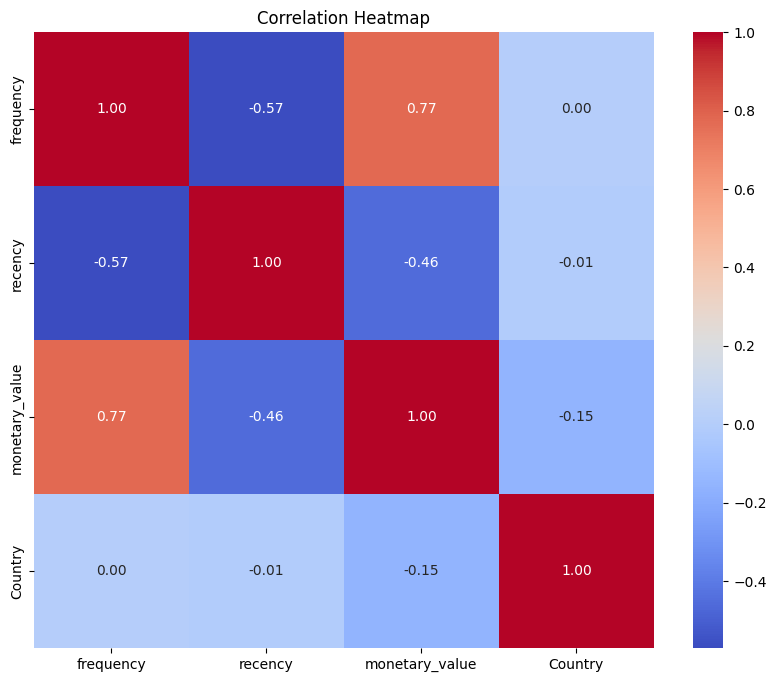

In [248]:
# Calculate the correlation matrix
correlation_matrix = df_grouped.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

# Show the plot
plt.title('Correlation Heatmap')
plt.show()

In [249]:
# Features and target variable
X = df_grouped.drop(columns=['Country'])  # Assuming 'Country' is not the target variable
y = df_grouped['monetary_value']  # Use 'monetary_value' or any other calculated CLV column as the target

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 0.0013194212077846544
R-squared: 0.9992902017991162
